In [1]:

#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
#pipeline imports
import env

#stats imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr

#sklearn imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

#math import
from math import sqrt

#project library
from wrangle import get_zillow_data
from wrangle import remove_outliers
from wrangle import split_data
from wrangle import robust_scaler_viz
from wrangle import data_to_samples

from model import baseline
from model import residual

#vizuals 
from vizuals import explore_vizuals
from vizuals import base_line_prediction_viz
from vizuals import validate_scatter_plot
from vizuals import residual_scatter_plot
from vizuals import validate_histogram
from vizuals import test_histogram

from explore import bivariate_categorical
from explore import pairplot_explore
from explore import question_1, question_2, question_3

#Hypothesis alpha
alpha = .05

### BY: Alejandro Velasquez


# project overview

We will analyze single-family units that were sold during the year 2017. Using the number of bathrooms the number of bathrooms and the square footage of the house we will try to predict the asses text amount.

# goals 
 conclusion that talks about your original goals and how you reached those (or didn't), the key findings, recommendations and next steps ("If I had more time, I would...")



- What will the end product look like?
    - A model that could improve Zillows pTax value prediction 
    
- Who will it be delivered to?
    Zillow Data Science team 

- How will it be used?
    - It won't, there is not enough data to be useful 

- How will I know I'm done?
    - it is time to stop working 

- What is my MVP?
    OLS model

- How will I know it's good enough?
    - variance will be high 
    - Beat baseline prediction\


In [2]:
df = get_zillow_data()

In [3]:
df.head()


,bedrooms,bathrooms,square_feet,year,tax_of_property,tax_assessed_value_target,fips,zip_code,transaction_date
0,2.0,1.0,775.0,1952.0,1056.05,74118.0,6037.0,96338.0,2017-09-18
1,4.0,2.0,1497.0,1949.0,6793.40,557360.0,6037.0,96420.0,2017-09-18
2,3.0,2.0,1337.0,1956.0,5314.35,459600.0,6037.0,96161.0,2017-09-18
3,4.0,2.0,1631.0,2002.0,3294.29,262657.0,6037.0,96361.0,2017-09-18
4,3.0,3.0,1454.0,1989.0,2410.40,130027.0,6037.0,97318.0,2017-09-18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bedrooms                   52441 non-null  float64
 1   bathrooms                  52441 non-null  float64
 2   square_feet                52359 non-null  float64
 3   year                       52325 non-null  float64
 4   tax_of_property            52437 non-null  float64
 5   tax_assessed_value_target  52440 non-null  float64
 6   fips                       52441 non-null  float64
 7   zip_code                   52415 non-null  float64
 8   transaction_date           52441 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


## Note:
Data was retrived using SQL and the names of the columns

- bedroomcnt as bedrooms
- calculatedfinishedsquarefeet as square_feet
- yearbuilt as year
- taxamount as tax_of_property
- axvaluedollarcnt as tax_assessed_value_target
- fips as fips
- regionidzip as zip_code
- transactiondate as transaction_date

# Initial questions


- Does the size of the house affect `tax_assessed_value_target` ---> x = square_feet
- Does the amount of bathrooms and bedrooms affect `tax_assessed_value_target` --> x = rooms_&_bathrooms (feature engeniering by adding rooms and bathrooms)
- Does zipcode affect `tax_assessed_value_target` ---> x = zip_code

In [5]:
# convert treansaction_date to date object type
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [6]:
# Create list of the names of the columsn 
df.columns.values

array(['bedrooms', 'bathrooms', 'square_feet', 'year', 'tax_of_property',
       'tax_assessed_value_target', 'fips', 'zip_code',
       'transaction_date'], dtype=object)

In [7]:
# Create value counts to see upper outliers
cols = df.columns.values
for col in cols:
    print(col.upper())
    print(df[col].value_counts(dropna=False,ascending=True).head(10))

BEDROOMS
14.0      1
11.0      1
10.0      2
12.0      3
9.0       8
8.0      24
7.0     106
0.0     137
1.0     612
6.0     635
Name: bedrooms, dtype: int64
BATHROOMS
13.0     1
18.0     1
11.0     3
8.5      3
10.0     5
9.0     13
7.5     16
6.5     47
8.0     53
7.0     88
Name: bathrooms, dtype: int64
SQUARE_FEET
4566.0     1
3103.0     1
11704.0    1
3861.0     1
4967.0     1
4780.0     1
4357.0     1
4203.0     1
7770.0     1
4536.0     1
Name: square_feet, dtype: int64
YEAR
1889.0    1
1880.0    1
1882.0    1
1897.0    1
1878.0    1
1892.0    1
1894.0    1
1893.0    3
2016.0    3
1887.0    3
Name: year, dtype: int64
TAX_OF_PROPERTY
1136.39     1
2818.02     1
3857.22     1
4871.52     1
15512.71    1
5838.96     1
9969.72     1
1602.96     1
19379.20    1
872.36      1
Name: tax_of_property, dtype: int64
TAX_ASSESSED_VALUE_TARGET
NaN          1
416775.0     1
358482.0     1
114633.0     1
1555151.0    1
1614974.0    1
382322.0     1
762655.0     1
296960.0     1
49636.0      1


In [8]:
# Create value counts to see lower end outliers
cols = df.columns.values
for col in cols:
    print(col.upper())
    print(df[col].value_counts(dropna=False,ascending=True).tail(30))

BEDROOMS
14.0        1
11.0        1
10.0        2
12.0        3
9.0         8
8.0        24
7.0       106
0.0       137
1.0       612
6.0       635
5.0      3973
2.0      8340
4.0     15240
3.0     23359
Name: bedrooms, dtype: int64
BATHROOMS
13.0        1
18.0        1
11.0        3
8.5         3
10.0        5
9.0        13
7.5        16
6.5        47
8.0        53
7.0        88
0.0       121
5.5       224
6.0       322
4.5       687
5.0       803
1.5       841
3.5       918
4.0      2227
2.5      3934
1.0      9568
3.0     10673
2.0     21893
Name: bathrooms, dtype: int64
SQUARE_FEET
1032.0     64
1242.0     65
1372.0     65
1288.0     66
1560.0     66
1540.0     67
864.0      67
1064.0     68
1008.0     69
1480.0     70
1536.0     70
1248.0     70
1320.0     71
1144.0     72
1240.0     73
1472.0     73
1260.0     73
1440.0     77
1296.0     78
1300.0     78
1570.0     79
NaN        82
1232.0     83
1400.0     83
1176.0     84
936.0      86
1040.0     86
1080.0    102
1200.0    119


## Takeaway 

- There are some null values. We will remove the those records 
    - 229 values
- I will drop year built as 
- Drop trasaction date as we won't be using it to predict our target value
- There are some ovious outliers that I will pull out before xpliting the data
    - Bedrooms (4 record)
        - 14
        - 11
        - 10
    - Bathrooms (4 records)
        - 13
        - 18
        - 8.5

# Prepare and remove outliers 

## Takeaway 

- There are some null values. We will remove the those records 
    - 229 values
- I will drop year built 
- Drop trasaction date as we won't be using it to predict our target value
- Drop houses that do not have a bathroom. Houses with 0 room can be studios or open floor layout
- Drop null values as they do not affect the size of our data significantly
- Drop houses smaller than 200 sqft



In [9]:
df.shape

(52441, 9)

In [10]:
df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'square_feet', 'year', 'tax_of_property', 'tax_assessed_value_target', 'zip_code'])
df.shape

(44472, 8)

### visualize data

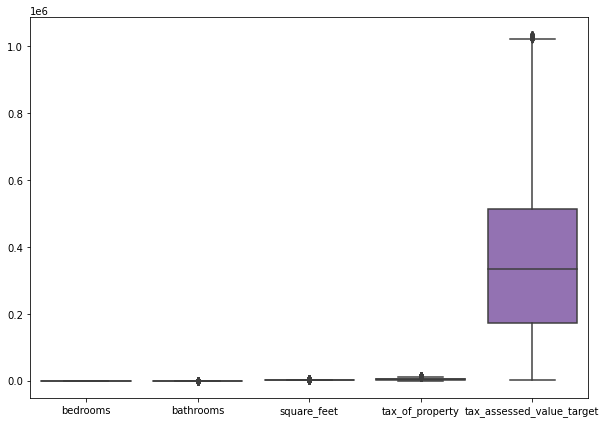

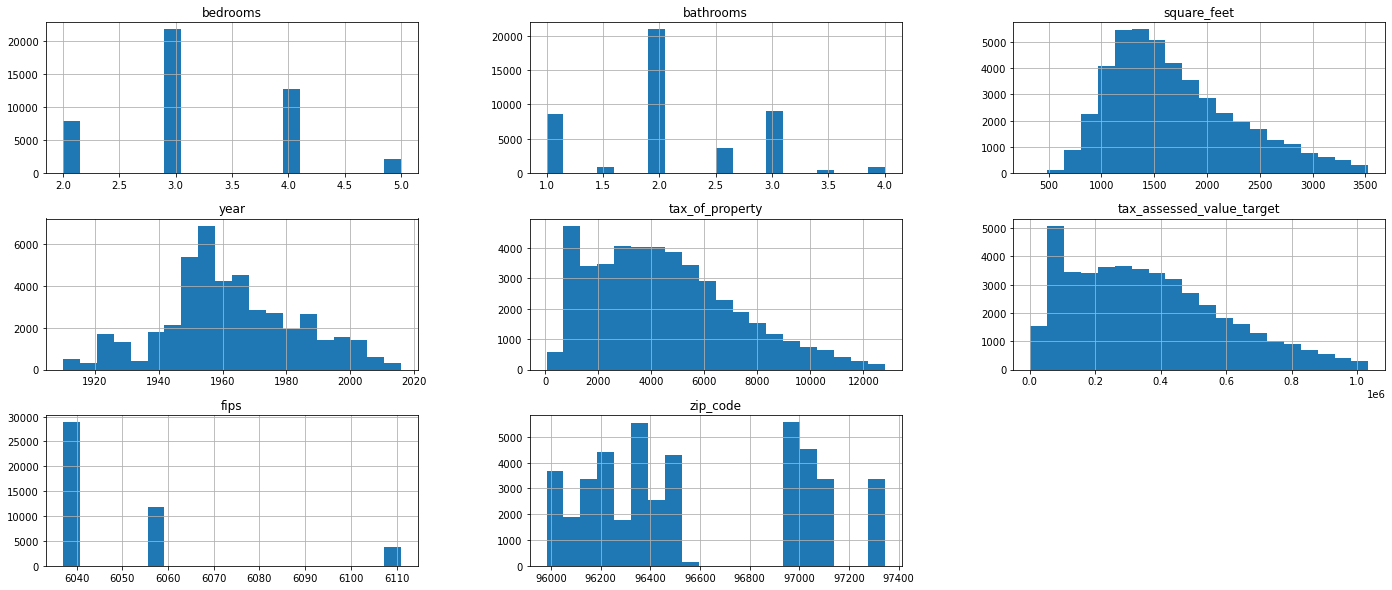

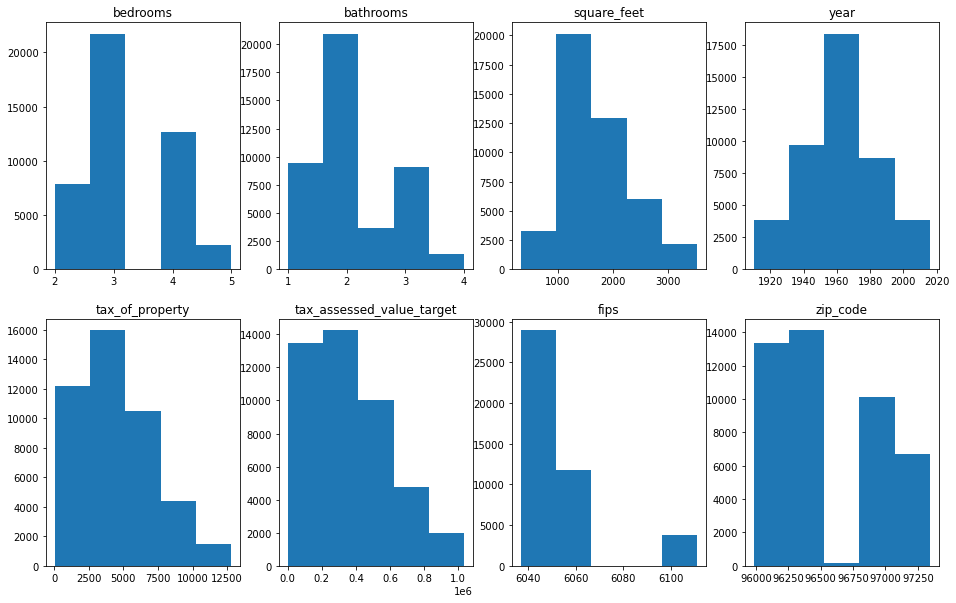

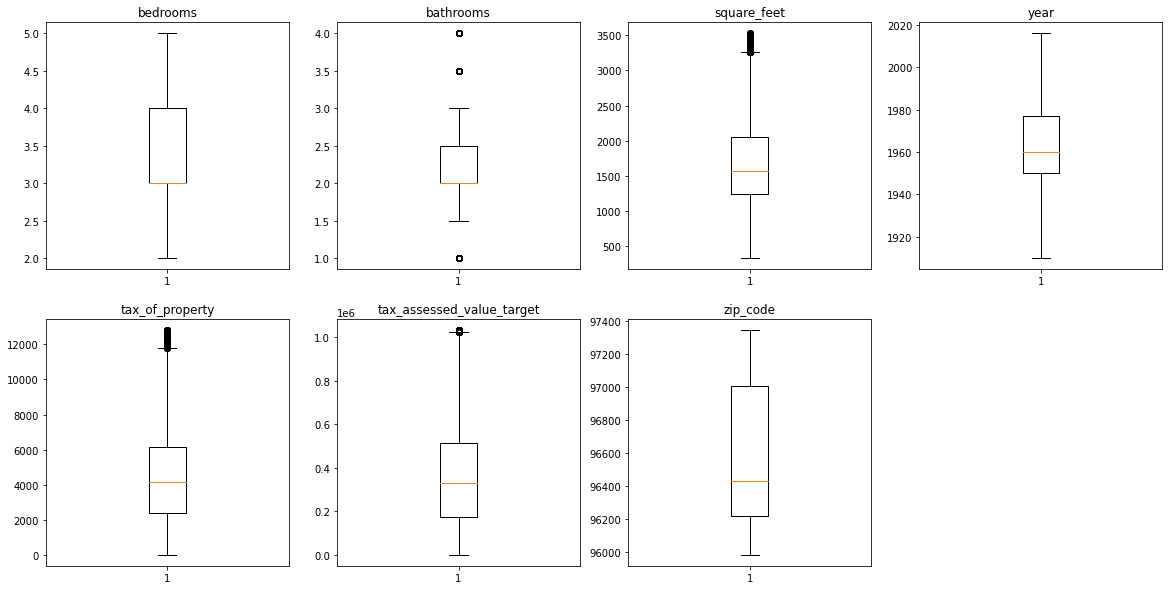

In [11]:
explore_vizuals(df)

## Vizuals Takeaways
- That seems normalized and ready for Some Exploration

- Some outliers are normal to have, it is stadard of all populations




# Split the Data

In [12]:
# Use split_data function from wrangle
train, validate, test = split_data(df)

In [13]:
train.shape, validate.shape, test.shape

((24903, 8), (10674, 8), (8895, 8))

# Scale the Data 

In [14]:
# Chose feaures to run
features = ['bedrooms', 'bathrooms', 'square_feet', 'year', 'fips', 'zip_code']
    

In [15]:
X_train, y_train, x_validate, y_validate, x_test, y_test = data_to_samples(features, train, validate, test)


In [16]:
X_train.shape, y_train.shape, x_validate.shape, y_validate.shape,  x_test.shape, y_test.shape



((24903, 6), (24903,), (10674, 6), (10674,), (8895, 6), (8895,))

In [17]:
x_validate

,bedrooms,bathrooms,square_feet,year,fips,zip_code
34438,4.0,2.5,3006.0,2002,6059,97037
49432,3.0,3.0,1172.0,1966,6111,96351
40508,4.0,2.0,1700.0,1964,6059,96185
34441,5.0,2.0,1623.0,1955,6059,97047
40004,3.0,4.0,2970.0,1998,6059,96989
...,...,...,...,...,...,...
2020,3.0,2.0,1809.0,2003,6037,96398
26287,3.0,2.0,1355.0,1955,6037,96171
39100,4.0,3.0,1956.0,1963,6059,97063
37435,3.0,2.0,1277.0,1950,6059,96981


In [18]:
"""
I had issues making it function so I decided to 
put all the code here in order to not lose time
"""


# Chose feaures to run
# Features representing x have been carefully pick to avoid target leakage
features = ['bedrooms', 'bathrooms', 'square_feet', 'year', 'fips', 'zip_code']
# Note that we only call .fit with the training data,
X_train = train[features]
y_train = pd.DataFrame(train.tax_assessed_value_target, columns=['tax_assessed_value_target'])
x_validate = validate[features]
y_validate = pd.DataFrame(validate.tax_assessed_value_target, columns=['tax_assessed_value_target'])
X_test = test[features]
y_test = pd.DataFrame(test.tax_assessed_value_target, columns=['tax_assessed_value_target'])
# Note that we only call .fit with the training data,
X_train = train[features]
x_validate = validate[features]
x_test = test[features]
# RobustScaler
# 1. create the object
scaler = RobustScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
# 2. fit the object
scaler.fit(X_train)
# 3. use the object
X_train_scaled = scaler.transform(X_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

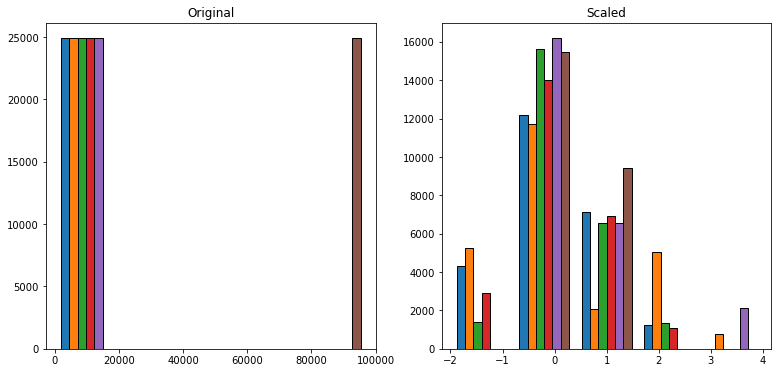

In [19]:
robust_scaler_viz(X_train, X_train_scaled)

# Exploration

“A hypothesis may be simply defined as a guess. A scientific hypothesis is an intelligent guess.” – Isaac Asimov

## - Initial questions

- Does the size of the house affect `tax_assessed_value_target` ---> x = square_feet
- Does the amount of bathrooms and bedrooms affect 
`tax_assessed_value_target` --> x = rooms_&_bathrooms (feature engeniering by adding rooms and bathrooms)
- Are the square feet related to the tax extimated value?
- Does zipcode affect `tax_assessed_value_target` ---> x = zip_code

### Note: 
- For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value

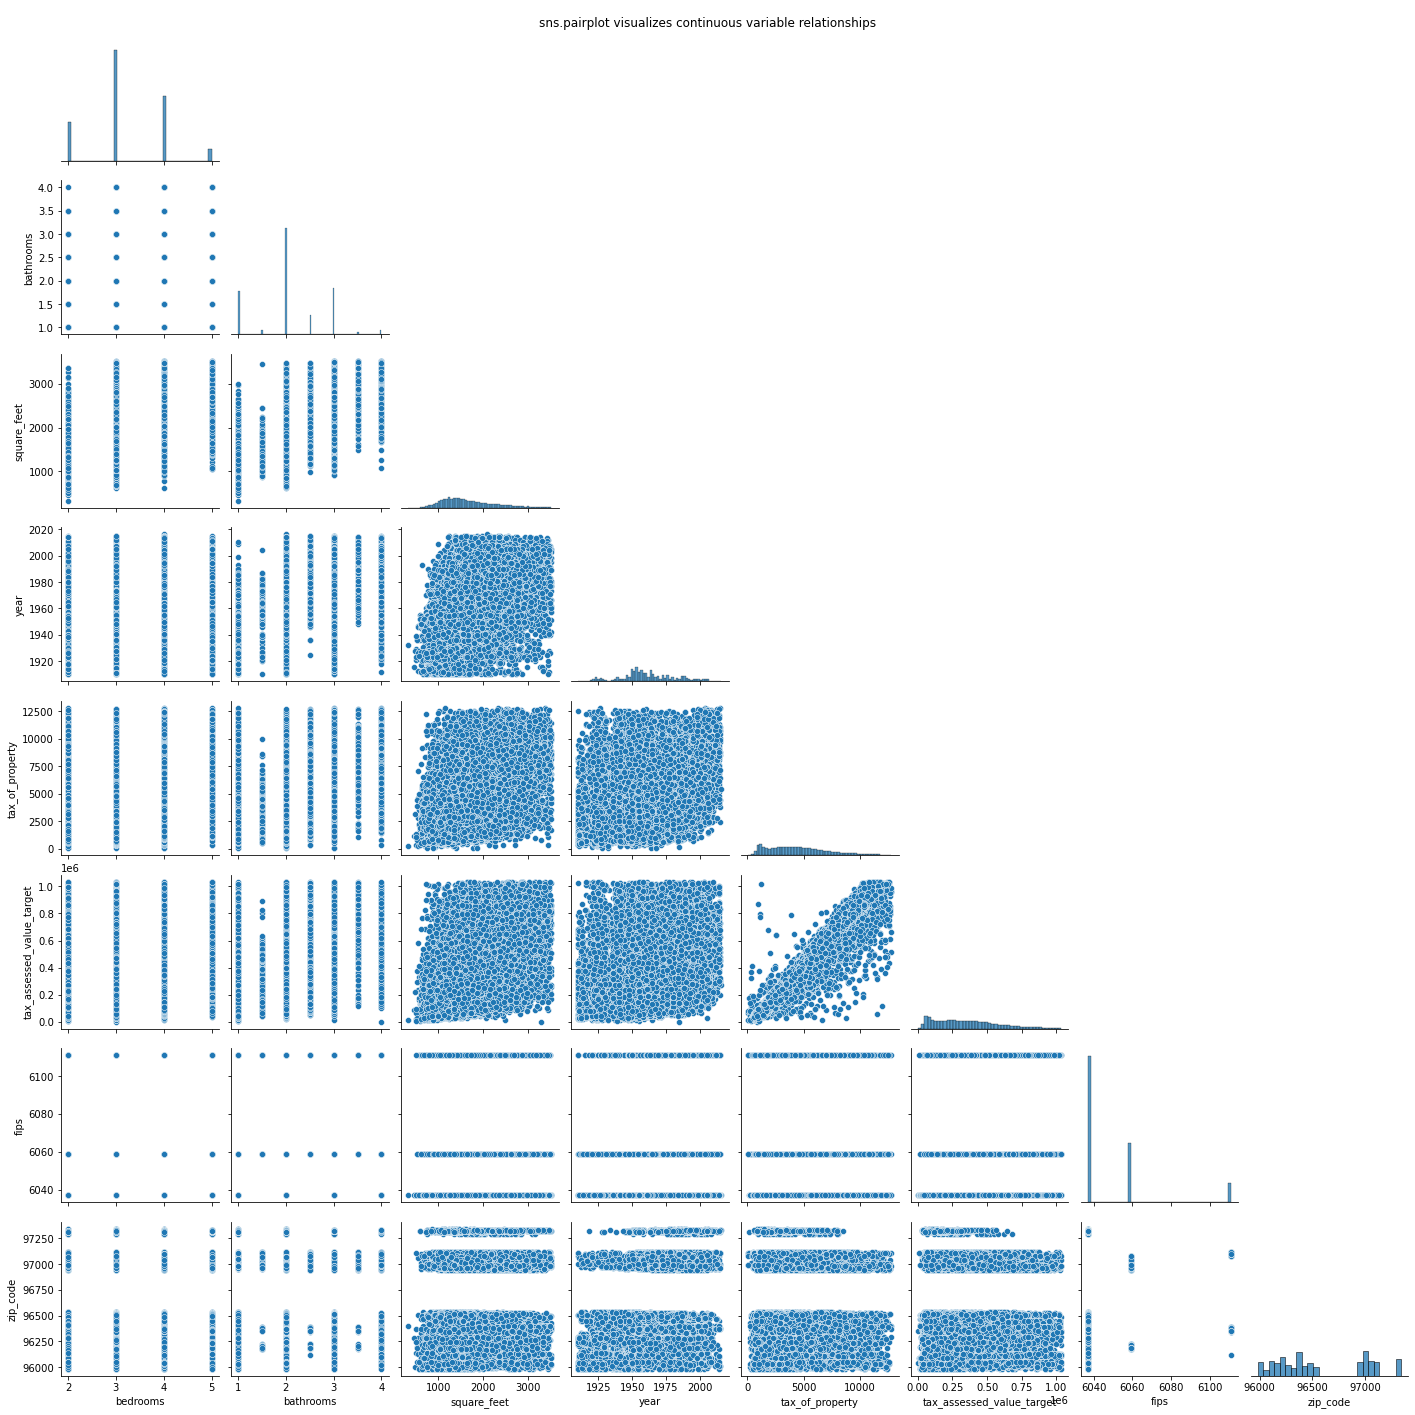

In [20]:
pairplot_explore(train)

# Takeaways 
- In this plot it is very clear that `tax_of_proprty` will generate target leak
- Homes with 1.5 bathrooms seem to be worth less than the rest

## Bivariate Exploration 

bedrooms vs tax_assessed_value_target


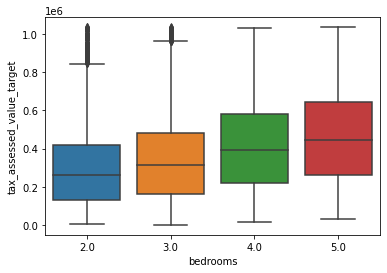

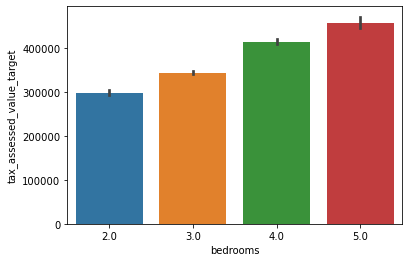

-------------------------------
Mean tax_assessed_value_target by bedrooms:  
bedrooms
2.0    298632.673242
3.0    344107.859777
4.0    414995.893072
5.0    458580.230152
Name: tax_assessed_value_target, dtype: float64

bathrooms vs tax_assessed_value_target


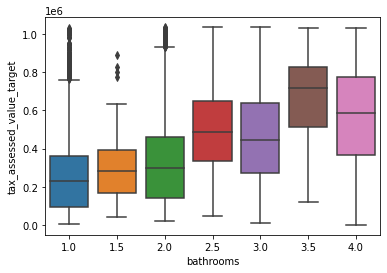

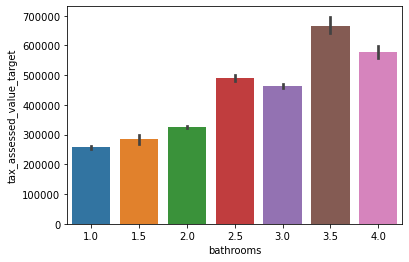

-------------------------------
Mean tax_assessed_value_target by bathrooms:  
bathrooms
1.0    257511.597095
1.5    284035.009174
2.0    326264.125447
2.5    490942.784578
3.0    463154.213962
3.5    666720.982833
4.0    577683.817490
Name: tax_assessed_value_target, dtype: float64

square_feet vs tax_assessed_value_target


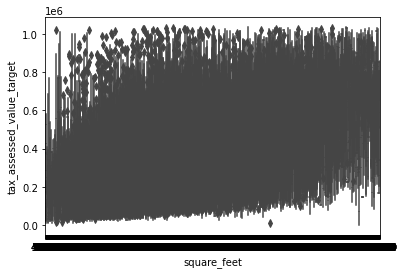

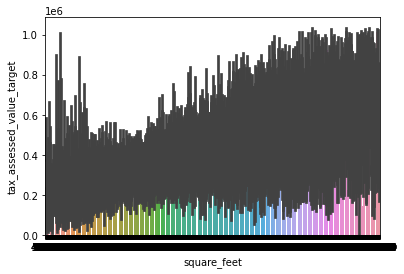

-------------------------------
Mean tax_assessed_value_target by square_feet:  
square_feet
326.0      16084.0
468.0      84758.0
484.0     217461.0
500.0      51625.5
504.0      22943.0
            ...   
3522.0    658967.5
3523.0    656508.0
3524.0    397278.0
3526.0    613279.0
3527.0    759514.0
Name: tax_assessed_value_target, Length: 2742, dtype: float64

year vs tax_assessed_value_target


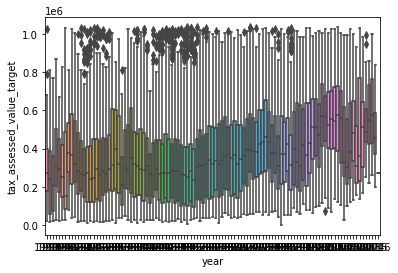

In [21]:
 bivariate_categorical('tax_assessed_value_target', ['bedrooms', 'bathrooms', 'square_feet', 'year', 'zip_code'], train)

## Hypothesis Testing

1. Do houses with more `bedrooms` have a higher `tax_assessed_value_target`?
2. Do houses with more `bathrooms` have a higher `tax_assessed_value_target`?
3. Do houses with higher `square_feet` have a higher `tax_assessed_value_target`?
4. does average square feet per zipcode affect the  `tax_assessed_value_target` or `tax_of_property`?

##### 1. Do houses with more `bedrooms` have a higher `tax_assessed_value_target`?

- $H_0$: There is no association between the number of bedroom and tax assessed value
- $H_a$: There is an association between the number of bedroom and tax assessed value


In [ ]:
question_1(train, alpha)

##### 2. Do houses with more `bedrooms` have a higher `tax_assessed_value_target`?

- $H_0$: There is no association between the number of bathrooms and tax assessed value
- $H_a$: There is an association between the number of bathrooms and tax assessed value

In [ ]:
question_2(train, alpha)

In [ ]:
# pandas crosstab to make a 'contingency' table
observe = pd.crosstab(train.tax_assessed_value_target, train.bathrooms)
chi2, p, degf, expected = stats.chi2_contingency(observe)
print('Observed\n')
print(observe.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis/")

##### 3. Do houses with more `square_feet` have a higher `tax_assessed_value_target`?

- $H_0$: There is no association between the size of the house in square feet and tax assessed value
- $H_a$: There is an association between the size of the house in square feet and tax assessed value

In [ ]:
question_3(train, alpha)

## Key Takeawy 

- There sees to be a relationship between the size of the house and the target
- It sees that the more bedrooms there are so does increase our target
- It seems that the more bathrooms there so does increse our target 


------------
# Modeling

### - Establish Baseline

##### As Y moves along the x axis target variable deacreses value 

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1 Predict mean
pred_mean = y_train.tax_assessed_value_target.mean()
y_train['baseline_pred_mean'] = pred_mean
y_validate['baseline_pred_mean'] = pred_mean

# 2. Predict median
pred_median = y_train.tax_assessed_value_target.median()
y_train['baseline_pred_median'] = pred_median
y_validate['baseline_pred_median'] = pred_median

# 3. RMSE of mean
rmse_train = mean_squared_error(y_train.tax_assessed_value_target, y_train.baseline_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_assessed_value_target, y_validate.baseline_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of median
rmse_train = mean_squared_error(y_train.tax_assessed_value_target, y_train.baseline_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_assessed_value_target, y_validate.baseline_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

      

In [ ]:
baseline(y_train, y_validate)

In [ ]:
base_line_prediction_viz(pred_mean, pred_median, y_train)

## OLS Model


In [ ]:
y_validate.shape, x_validate.shape

In [ ]:
# Create model
lm = LinearRegression(normalize=True,)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_assessed_value_target)

# predict train
y_train['taxvalue_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_assessed_value_target, y_train.taxvalue_pred_lm)**(1/2)

# predict validate
y_validate['taxvalue_pred_lm'] = lm.predict(x_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_assessed_value_target, y_validate.taxvalue_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

## LassoLars Model

In [ ]:
# create the model object
lars = LassoLars(alpha=50000.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_assessed_value_target)

# predict train
y_train['taxvalue_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_assessed_value_target, y_train.taxvalue_pred_lars)**(1/2)

# predict validate
y_validate['taxvalue_pred_lars'] = lars.predict(x_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_assessed_value_target, y_validate.taxvalue_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

# TweedieRegressor (GLM)


In [ ]:
# create the model object
glm = TweedieRegressor(power=10, alpha=0.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_assessed_value_target)

# predict train
y_train['taxvalue_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_assessed_value_target, y_train.taxvalue_pred_glm)**(1/2)

# predict validate
y_validate['taxvalue_pred_glm'] = glm.predict(x_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_assessed_value_target, y_validate.taxvalue_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

# Evaluate 
#### Use Validate data set

In [ ]:
df['y_hat'] = glm.predict(df[features])

#computes y hat baseline
df['yhat_baseline'] = df['tax_assessed_value_target'].mean()

## Validating Visuals
A scatter plot of each models' predictions vs the actual tax values. The ideal line for my predictions is plotted for reference. There is a lot of overlap, but there is a slightly better fit for the polynomial model, displayed in yellow.

In [ ]:
validate_scatter_plot(y_validate, pred_mean)

## Residual Plots: Plotting the Errors in Predictions

In [ ]:
residual_scatter_plot(y_validate, pred_mean)

### Histogram


In [ ]:
validate_histogram(y_validate)

## Model selected: lm (using LinearRegression)

- Model selected: lm (using LinearRegression)
- Model selected: lars (using LassoLars Model)

## Evaluate on Test

In [ ]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['taxvalue_pred_lm'] = lm.predict(x_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_assessed_value_target, y_test.taxvalue_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

evs = explained_variance_score(y_test.tax_assessed_value_target, y_test.taxvalue_pred_lm)
print('Test Explained Variance = ', round(evs,2))


In [ ]:
# I wanted to test another model just to make sure that the linear model I chose was the best

y_test = pd.DataFrame(y_test)

# predict on test
y_test['taxvalue_pred_lars'] = lars.predict(x_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_assessed_value_target, y_test.taxvalue_pred_lars)**(1/2)

print("RMSE for LARS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

evs = explained_variance_score(y_test.tax_assessed_value_target, y_test.taxvalue_pred_lars)
print('Test Explained Variance = ', round(evs,5))


In [ ]:
test_histogram(y_test)

# Conclusion



# Conclusion

## What features matter?
Square footage has the most weight, also predicting the tax value.

## Modeling
For the final model, liner regression was used as it had the best Variance 

## Recommendations
Use more features and more time 👍

## Next Steps
With more time, I would like to bring other features from the more extensive data set and dedicate more time to feature engineering to find better insights. 